## 0. Load Data

In [1]:
dataname = 'abalone'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
df = pd.read_csv('../datasets/OD/%s/meta_data/%s.original.csv'%(dataname, dataname))
gt = pd.read_csv('../datasets/OD/%s/meta_data/%s.diff.csv'%(dataname, dataname))['ground.truth']
gt_idx = gt.index.values[gt == 'anomaly']

In [3]:
df.head()

,Y,F1,V1,V2,V3,V4,V5,V6,V7
0,15,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,7,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,9,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,10,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,7,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [4]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [5]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [6]:
pf.session.load_data(src=DF, df=df, check_param=True)

INFO:profiler.utility:[0.00882101058959961] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'nan', '?', 'unknown', 'NaN', 'None', 'none'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "Y": "numeric",
    "F1": "categorical",
    "V1": "numeric",
    "V2": "numeric",
    "V3": "numeric",
    "V4": "numeric",
    "V5": "numeric",
    "V6": "numeric",
    "V7": "numeric"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'Y': ['equal'], 'F1': ['equal'], 'V1': ['equal'], 'V2': ['equal'], 'V3': ['equal'], 'V4': ['equal'], 'V5': ['equal'], 'V6': ['equal'], 'V7': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.02831411361

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [7]:

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [8]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [9]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.05835890769958496] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 9 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 9, and the bound is 0.00017033
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 9/9 [00:00<00:00, 223.70it/s]
INFO:profiler.data.transformer:Number of training samples: 37593
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[0.18682312965393066] Create Training Data execution time: 0.1284642219543457



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [10]:
autoregress_matrix = pf.session.learn_structure(sparsity=0,
                                                infer_order=True)

INFO:profiler.utility:[0.19304490089416504] Learn Structure start

INFO:profiler.learner:use threshold 0.0688
INFO:profiler.utility:[0.3168201446533203] Learn Structure execution time: 0.12377524375915527



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [11]:
parent_sets = pf.session.get_dependencies(score="fit_error")


INFO:profiler.utility:[0.322268009185791] Get Dependencies start

INFO:profiler.utility:[0.3532719612121582] Get Dependencies execution time: 0.031003952026367188



V3 -> V4 (0.2008338812632871)
V3,V4 -> V5 (0.18094646861090313)
V3,V4,V5 -> V6 (0.1895513423865562)
V3,V4,V5,V6 -> V7 (0.1915081866856929)
V3,V4,V7 -> V2 (0.19611317528179012)
V4,V7,V2 -> V1 (0.192234024859124)
V7 -> F1 (0.24970344566920666)


## 5. Visualization

In [12]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

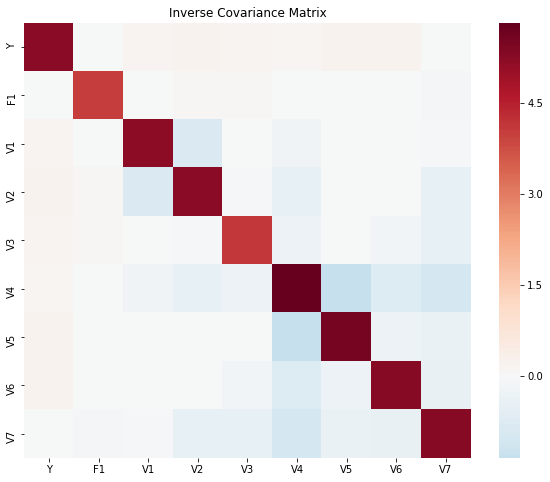

In [13]:
pf.session.visualize_inverse_covariance()

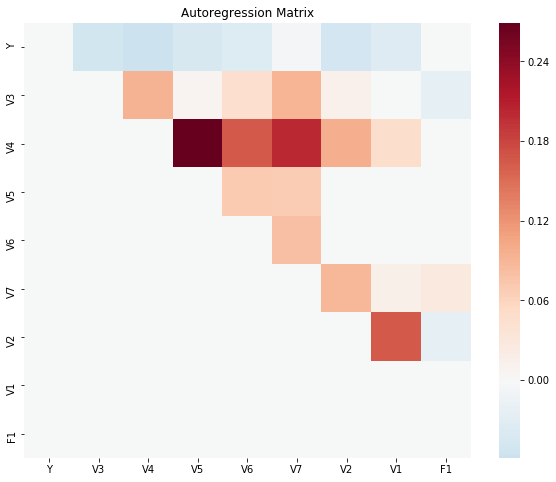

In [14]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()


,time_point,msg,execution_time
0,0.008821,start: Load Data,0.000000
1,0.028314,end: Load Data,0.019493
2,0.058359,start: Create Training Data,0.000000
3,0.186823,end: Create Training Data,0.128464
4,0.193045,start: Learn Structure,0.000000
5,0.316820,end: Learn Structure,0.123775
6,0.322268,start: Get Dependencies,0.000000
7,0.353272,end: Get Dependencies,0.031004
8,0.353272,total_execution_time,0.302737


## 6. Outlier Detection

In [16]:
from profiler.app.od import *

In [17]:
# detector = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="isf", gt_idx=gt_idx, min_neighbors=20)
# detector.run_all(parent_sets)
# detector.evaluate()

In [18]:
detector2 = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="ocsvm", gt_idx=gt_idx,
                           nu=0.1, gamma='auto', min_neighbors=50, knn=True, neighbor_size=100, 
                           tol=0.01, high_dim=True)
detector2.run_all(parent_sets)

INFO:profiler.utility:[0.0006809234619140625] naive start

INFO:profiler.utility:[0.738893985748291] naive execution time: 0.738213062286377

INFO:profiler.utility:[0.7395498752593994] structured start

100%|██████████| 9/9 [00:27<00:00,  3.02s/it]
INFO:profiler.utility:[27.956187963485718] structured execution time: 27.21663808822632



   time_point                   msg  execution_time
0    0.000681          start: naive        0.000000
1    0.738894            end: naive        0.738213
2    0.739550     start: structured        0.000000
3   27.956188       end: structured       27.216638
4   27.956188  total_execution_time       27.954851


Results for naive approach:
with 3408 detected outliers, precision is: 0.5552
with 6882 detected outliers, recall is: 0.9092
f1: 0.6894
Results for structure only:
with 422 detected outliers, precision is: 0.5427
with 422 detected outliers, recall is: 0.1100
f1: 0.1830
Results for enhance naive with structured:
with 3448 detected outliers, precision is: 0.5537
with 7304 detected outliers, recall is: 0.9173
f1: 0.6905


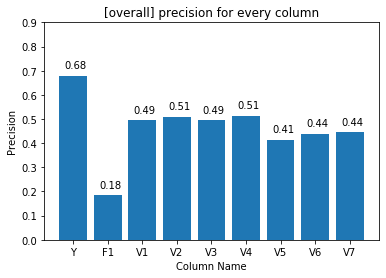

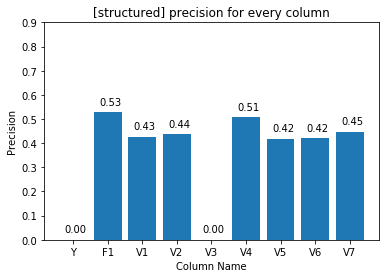

In [19]:
detector2.evaluate(t=0.05)